<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/Multivariable_Regression_Predictive_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariable Regression / Predictive Modelling**

1. **Defining the Outcome (Y)**: CVD
 - As before, we need to construct a binary CVD variable since the direct variable isn't present:
     - **hltprhc** : Health problems, last 12 months: heart or circulation problem
     - **hltprhb** : Health problems, last 12 months: high blood pressure
     - **hltphhc** : Health problems, hampered, last 12 month: heart or circulation problem
     - **hltphhb** : Health problems, hampered, last 12 month: high blood pressure

2. **Defining Predictors (X)**: Building Nested Models
 - **Model 1: Demographics**(age, sex)
   - **agea**: Age of respondent, calculated
   - **gndr**: Gender
 - **Model 2: + Socioeconomic** (education, income)
   - **edulvlb**: Highest level of education
   - **hinctnta**: Household's total net income, all sources
   - **mainact**: Main activity last 7 days (employment).
 - **Model 3: + Lifestyle** (smoking, BMI, alcohol, diet)
   - **cgtsmok**: Cigarette smoking behaviour
   - **BMI**: Calculated Body Mass Index (as previously described using weighta and height)
   - **alcfreq**: How often drink alcohol
   - **etfruit**: How often eat fruit, excluding drinking juice
   - **eatveg**: How often eat vegetables or salad, excluding potatoes
   - **dosprt**: Do sports or other physical activity, how many of last 7 days
   - **slprl**: sleep was restless,how often past week
 - **Model 4: + Country Fixed Effects or multilevel random intercepts (country)**
   - **cntry**: Country - this needs to be a factor variable in Python.
- Report ORs, SEs, SDs, 90% & 95% CIs, p-values. Provide sample size per model.

3. **Diagnostics**
 - Discrimination: AUC (ROC).
 - Calibration: calibration plot + Brier score.
 - If multilevel: report ICC (for logistic: var_country/(var_country + pi^2/3) approximation) and possibly random slopes for key exposures.

**File outputs**
 - tables/regression_models.csv and fig_roc_calibration.png.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Import the os module
from sklearn.calibration import calibration_curve

# --- Helper functions ---
def calculate_odds_ratio_and_ci(model_output):
    odds_ratios = np.exp(model_output.params)
    standard_errors = model_output.bse
    ci_90 = np.exp(model_output.conf_int(alpha=0.1))
    ci_95 = np.exp(model_output.conf_int(alpha=0.05))
    p_values = model_output.pvalues

    results_df = pd.DataFrame({
        'OR': odds_ratios,
        'SE': standard_errors,
        'lower_90CI': ci_90.iloc[:, 0],
        'upper_90CI': ci_90.iloc[:, 1],
        'lower_95CI': ci_95.iloc[:, 0],
        'upper_95CI': ci_95.iloc[:, 1],
        'p_value': p_values
    })

    return results_df

def plot_calibration_curve(y_true, y_prob, ax, model_name):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)

    ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label=model_name)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(f'Calibration Curve ({model_name})')
    ax.legend()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

def analyze_multilevel_logistic_regression(df, formula, group_variable):
    md = smf.mixedlm(formula, data=df, groups=df[group_variable])
    mdf = md.fit()

    vc = mdf.vcov_re
    var_country = vc[group_variable]["Intercept"]
    var_residual = np.pi**2 / 3

    icc = var_country / (var_country + var_residual)

    return mdf, icc


# --- Main analysis ---
try:
    df = pd.read_csv('/content/ESS11.csv', low_memory=False)  # Added low_memory=False
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Check '/content/ESS11.csv' path.")

print("Step 0: Loaded dataset.")

# -------------------------
# 1. Add new columns
# -------------------------
# Convert columns to numeric, handling errors
cols_to_convert = ["hltprhc", "hltprhb", "hltphhc", "hltphhb"]
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric and coerce errors to NaN

# Impute missing values
df[cols_to_convert] = df[cols_to_convert].fillna(0)

# Add the new CVD column
df["CVD"] = df[["hltprhc", "hltprhb", "hltphhc", "hltphhb"]].sum(axis=1)

print("Step 1: update DataFrame 'hltprhc', 'hltprhb', 'hltphhc', 'hltphhb' to 'CVD'")

# -------------------------
# 2. Data cleaning & required cols
# -------------------------
key_cols = ['weighta', 'height', 'CVD', 'etfruit', 'eatveg', 'dosprt','slprl', 'mainact',
            'cgtsmok', 'alcfreq', 'alcwkdy', 'alcwknd', 'edulvlb', 'hinctnta', 'agea', 'gndr', 'cntry']
missing_cols = [c for c in key_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"The following required columns are missing from the dataframe: {missing_cols}")

df = df.dropna(subset=key_cols).copy()
print(f"Step 2: Dropped rows with NA in key columns. Remaining rows: {len(df)}")

# Convert height from cm to meters and compute BMI
df['height_m'] = df['height'] / 100.0
df['BMI'] = df['weighta'] / (df['height_m'] ** 2)
df = df[np.isfinite(df['BMI'])].copy()
print("Step 3: Calculated BMI and removed infinite values.")

# Convert CVD to binary (0 or 1)
# Sum CVD and binarize it: If the sum is greater than 0, consider it as CVD present (1), otherwise, no CVD (0).
df['CVD'] = (df['CVD'] > 0).astype(int)
print(f"Unique values in Y (CVD): {np.unique(df['CVD'])}")

# --- Create Region Variable (Example) ---


region_mapping = {
    'AT': 'West',  # Austria
    'BE': 'West',  # Belgium
    'CH': 'West',  # Switzerland
    'CZ': 'East',  # Czech Republic
    'DE': 'West',  # Germany
    'ES': 'South', # Spain
    'FI': 'North', # Finland
    'FR': 'West',  # France
    'GB': 'West',  # United Kingdom
    'HU': 'East',  # Hungary
    'IE': 'West',  # Ireland
    'IT': 'South', # Italy
    'NL': 'West',  # Netherlands
    'NO': 'North', # Norway
    'PL': 'East',  # Poland
    'PT': 'South', # Portugal
    'SE': 'North', # Sweden
    'SI': 'East'   # Slovenia

}

df['region'] = df['cntry'].map(region_mapping)

# Handle missing regions:
if df['region'].isnull().any():
    print("Warning: Missing region values.  Check 'region_mapping'.")
    df['region'] = df['region'].fillna('Unknown') # Or drop rows: df = df.dropna(subset=['region'])

print(f"Unique values in region: {df['region'].unique()}")

# --- Define Models ---
models = {
    'Model 1: Demographics': ['agea', 'gndr'],
    'Model 2: + Socioeconomic': ['agea', 'gndr', 'edulvlb', 'hinctnta','mainact'],
    'Model 3: + Lifestyle': ['agea', 'gndr', 'edulvlb', 'hinctnta', 'cgtsmok', 'BMI', 'alcfreq', 'etfruit', 'eatveg', 'dosprt','slprl'],
    'Model 4: + Region Fixed Effects': ['agea', 'gndr', 'edulvlb', 'hinctnta', 'cgtsmok', 'BMI', 'alcfreq', 'etfruit', 'eatveg', 'dosprt', 'C(region)'] #Region fixed effects

}

# --- Results Storage ---
results = {}
roc_auc_scores = {}

# --- Diagnostics setup ---
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
axes = axes.flatten()

# --- Model fitting loop ---
for i, (model_name, predictors) in enumerate(models.items()):
    print(f"\n--- Fitting {model_name} ---")

    # --- Model Formula ---
    formula = f"CVD ~ {' + '.join(predictors)}"

    # --- Fit Logistic Regression ---
    if 'C(region)' in formula:  # Model 4
        try:
            model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            continue
    else:  # Models 1-3
        try:
            model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            continue

    # --- Store Results ---
    results[model_name] = {}
    results[model_name]['sample_size'] = len(df)

    # --- Calculate ORs and CIs ---
    results_df = calculate_odds_ratio_and_ci(model)
    results[model_name]['coefficients'] = results_df

    # --- Discrimination (AUC) ---
    y_prob = model.predict(df)
    try:
        auc = roc_auc_score(df['CVD'], y_prob)
        results[model_name]['auc'] = auc
        roc_auc_scores[model_name] = auc
        print(f"{model_name} AUC: {auc:.3f}")
    except ValueError as e:
        print(f"AUC calculation error for {model_name}: {e}")
        results[model_name]['auc'] = np.nan
        roc_auc_scores[model_name] = np.nan


    # --- Calibration ---
    brier_score = brier_score_loss(df['CVD'], y_prob)
    results[model_name]['brier_score'] = brier_score
    print(f"{model_name} Brier Score: {brier_score:.3f}")

    # --- Calibration Plot ---
    plot_calibration_curve(df['CVD'], y_prob, axes[i], model_name)

# --- Model 4 (Multilevel) ---

# --- Save results to CSV ---
# Create the 'tables' directory if it doesn't exist
if not os.path.exists('tables'):
    os.makedirs('tables')

output_data = []
for model_name, model_results in results.items():
    if "coefficients" in model_results:
        for predictor, row in model_results['coefficients'].iterrows():
            output_data.append([
                model_name,
                predictor,
                model_results['sample_size'],
                row['OR'],
                row['SE'],
                row['lower_90CI'],
                row['upper_90CI'],
                row['lower_95CI'],
                row['upper_95CI'],
                row['p_value'],
                model_results.get('auc', None),
                model_results.get('brier_score', None),
                model_results.get('icc', None)

            ])

output_df = pd.DataFrame(output_data, columns=[
    'Model', 'Predictor', 'SampleSize', 'OR', 'SE', 'Lower90CI', 'Upper90CI',
    'Lower95CI', 'Upper95CI', 'PValue', 'AUC', 'BrierScore','ICC'
])

output_df.to_csv('tables/regression_models.csv', index=False)

# --- Save calibration plot ---
# Create the directories for the figure if they don't exist
if not os.path.exists(os.path.dirname('fig_roc_calibration.png')) and os.path.dirname('fig_roc_calibration.png') != '':  # added check if directory name is empty
    os.makedirs(os.path.dirname('fig_roc_calibration.png'))


plt.tight_layout()
plt.savefig('fig_roc_calibration.png')
plt.close()

print("\n--- Analysis Complete ---")
print("Results saved to tables/regression_models.csv and fig_roc_calibration.png")

print("\n--- Key results  ---")
for model_name, auc in roc_auc_scores.items():
    print(f"{model_name} AUC: {auc:.3f}")

Step 0: Loaded dataset.
Step 1: update DataFrame 'hltprhc', 'hltprhb', 'hltphhc', 'hltphhb' to 'CVD'
Step 2: Dropped rows with NA in key columns. Remaining rows: 46162
Step 3: Calculated BMI and removed infinite values.
Unique values in Y (CVD): [0 1]
Unique values in region: ['West' 'Unknown' 'South' 'North' 'East']

--- Fitting Model 1: Demographics ---
Model 1: Demographics AUC: 0.775
Model 1: Demographics Brier Score: 0.192

--- Fitting Model 2: + Socioeconomic ---
Model 2: + Socioeconomic AUC: 0.675
Model 2: + Socioeconomic Brier Score: 0.188

--- Fitting Model 3: + Lifestyle ---
Model 3: + Lifestyle AUC: 0.654
Model 3: + Lifestyle Brier Score: 0.184

--- Fitting Model 4: + Region Fixed Effects ---
Model 4: + Region Fixed Effects AUC: 0.656
Model 4: + Region Fixed Effects Brier Score: 0.186

--- Analysis Complete ---
Results saved to tables/regression_models.csv and fig_roc_calibration.png

--- Key results  ---
Model 1: Demographics AUC: 0.775
Model 2: + Socioeconomic AUC: 0.675
M


--- Fitting Model 1: Demographics ---
Model 1: Demographics AUC: 0.775
Model 1: Demographics Brier Score: 0.192

--- Fitting Model 2: + Socioeconomic ---
Model 2: + Socioeconomic AUC: 0.675
Model 2: + Socioeconomic Brier Score: 0.188

--- Fitting Model 3: + Lifestyle ---
Model 3: + Lifestyle AUC: 0.654
Model 3: + Lifestyle Brier Score: 0.184

--- Fitting Model 4: + Region Fixed Effects ---
Model 4: + Region Fixed Effects AUC: 0.656
Model 4: + Region Fixed Effects Brier Score: 0.186


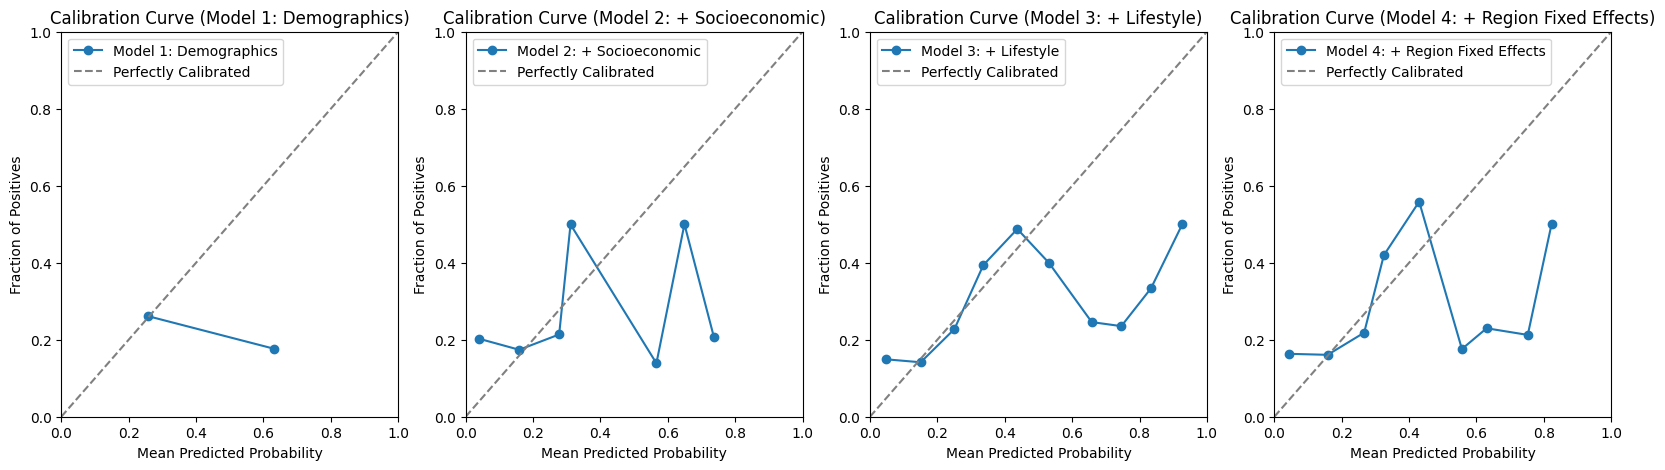

In [2]:
# --- Results Storage ---
results = {}
roc_auc_scores = {}

# --- Diagnostics setup ---
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
axes = axes.flatten()

# --- Model fitting loop ---
for i, (model_name, predictors) in enumerate(models.items()):
    print(f"\n--- Fitting {model_name} ---")

    # --- Model Formula ---
    formula = f"CVD ~ {' + '.join(predictors)}"

    # --- Fit Logistic Regression ---
    if 'C(region)' in formula:  # Model 4
        try:
            model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            continue
    else:  # Models 1-3
        try:
            model = sm.formula.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            continue

    # --- Store Results ---
    results[model_name] = {}
    results[model_name]['sample_size'] = len(df)

    # --- Calculate ORs and CIs ---
    results_df = calculate_odds_ratio_and_ci(model)
    results[model_name]['coefficients'] = results_df

    # --- Discrimination (AUC) ---
    y_prob = model.predict(df)
    auc = roc_auc_score(df['CVD'], y_prob)
    results[model_name]['auc'] = auc
    roc_auc_scores[model_name] = auc
    print(f"{model_name} AUC: {auc:.3f}")

    # --- Calibration ---
    brier_score = brier_score_loss(df['CVD'], y_prob)
    results[model_name]['brier_score'] = brier_score
    print(f"{model_name} Brier Score: {brier_score:.3f}")

    # --- Calibration Plot ---
    plot_calibration_curve(df['CVD'], y_prob, axes[i], model_name)


In [3]:
import pandas as pd
from IPython.display import display, HTML

def display_side_by_side(*args, titles=('',), justify="center"):
    """
    Displays pandas DataFrames side by side with optional titles.
    """
    html_str=''
    if len(titles)>0:
        html_str += "<table style='display: inline-table;'><tr>"
        for title in titles:
            html_str += "<td style='text-align:center'><h4 >{}</h4></td>".format(title)
        html_str += "</tr></table>"

    html_str += "<table style='border:none'>"
    html_str+="<tr style='border:none'>"
    for df in args:
        html_str+="<td style='vertical-align:top'>"
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="</td>"
    html_str+="</tr></table>"
    display(HTML(html_str))


# Paths to the CSV files
reg_csv_path = '/content/tables/regression_models.csv'


# Load the regression results CSV
try:
    reg_df = pd.read_csv(reg_csv_path)
except FileNotFoundError:
    print(f"Error: Regression results CSV file not found at {reg_csv_path}")
    reg_df = None # Set reg_df to None if file not found
except Exception as e:
    print(f"Error reading regression results CSV: {e}")
    reg_df = None # Set reg_df to None if other error reading file

if reg_df is not None:
    display(HTML(reg_df.to_html()))

,Model,Predictor,SampleSize,OR,SE,Lower90CI,Upper90CI,Lower95CI,Upper95CI,PValue,AUC,BrierScore,ICC
0,Model 1: Demographics,Intercept,46162,0.315550,0.034981,0.297906,0.334239,0.294640,0.337944,1.988089e-238,0.775341,0.192017,NaN
1,Model 1: Demographics,agea,46162,1.001689,0.000114,1.001501,1.001877,1.001465,1.001913,1.680413e-49,0.775341,0.192017,NaN
2,Model 1: Demographics,gndr,46162,1.005036,0.021320,0.970401,1.040907,0.963903,1.047924,8.137382e-01,0.775341,0.192017,NaN
3,Model 2: + Socioeconomic,Intercept,46162,0.409832,0.048459,0.378433,0.443836,0.372698,0.450665,1.144957e-75,0.675288,0.188017,NaN
4,Model 2: + Socioeconomic,agea,46162,1.002037,0.000122,1.001836,1.002238,1.001798,1.002276,1.280183e-62,0.675288,0.188017,NaN
5,Model 2: + Socioeconomic,gndr,46162,1.010772,0.021520,0.975619,1.047191,0.969026,1.054316,6.185739e-01,0.675288,0.188017,NaN
6,Model 2: + Socioeconomic,edulvlb,46162,0.999672,0.000033,0.999618,0.999727,0.999607,0.999737,4.377134e-23,0.675288,0.188017,NaN
7,Model 2: + Socioeconomic,hinctnta,46162,0.989891,0.000400,0.989239,0.990542,0.989114,0.990667,3.074765e-142,0.675288,0.188017,NaN
8,Model 2: + Socioeconomic,mainact,46162,1.000752,0.000505,0.999920,1.001583,0.999761,1.001743,1.369976e-01,0.675288,0.188017,NaN
9,Model 3: + Lifestyle,Intercept,46162,0.262980,0.049349,0.242477,0.285217,0.238736,0.289687,2.475450e-161,0.654332,0.184033,NaN


In [4]:
import pandas as pd
from IPython.display import display, HTML

def display_side_by_side(*args, titles=('',), justify="center"):
    """
    Displays pandas DataFrames side by side with optional titles.
    """
    html_str=''
    if len(titles)>0:
        html_str += "<table style='display: inline-table;'><tr>"
        for title in titles:
            html_str += "<td style='text-align:center'><h4 >{}</h4></td>".format(title)
        html_str += "</tr></table>"

    html_str += "<table style='border:none'>"
    html_str+="<tr style='border:none'>"
    for df in args:
        html_str+="<td style='vertical-align:top'>"
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="</td>"
    html_str+="</tr></table>"
    display(HTML(html_str))


# Paths to the CSV files
reg_csv_path = '/content/tables/regression_models.csv'


# Load the regression results CSV
try:
    reg_df = pd.read_csv(reg_csv_path)
except FileNotFoundError:
    print(f"Error: Regression results CSV file not found at {reg_csv_path}")
    reg_df = None  # Set reg_df to None if file not found
except Exception as e:
    print(f"Error reading regression results CSV: {e}")
    reg_df = None  # Set reg_df to None if other error reading file

# Define the output HTML file path
output_html_file = 'regression_results.html'

if reg_df is not None:
    # Generate HTML representation of the DataFrame
    html_output = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Regression Results</title>
    </head>
    <body>
    <h2>Regression Results</h2>
    """
    html_output += reg_df.to_html()
    html_output += """
    </body>
    </html>
    """

    # Save the HTML output to a file
    try:
        with open(output_html_file, 'w') as f:
            f.write(html_output)
        print(f"Regression results saved to {output_html_file}")
    except Exception as e:
        print(f"Error saving HTML output: {e}")

Regression results saved to regression_results.html


**Key Observations and Interpretations**
- **Model Progression**: The analysis examines four models, each progressively adding more variable categories:
   - **Model 1**: Demographics (age, gender)
   - **Model 2**: + Socioeconomic factors (education level, household income, main activity)
   - **Model 3**: + Lifestyle factors (smoking, BMI, alcohol frequency, fruit/vegetable consumption, sport participation, sleep)
   - **Model 4**: + Region Fixed Effects
- **Intercept Changes**: The intercept's Odds Ratio (OR) changes substantially across models, indicating that the baseline odds of the outcome vary significantly as more predictors are included. This suggests that demographic, socioeconomic, lifestyle, and regional factors all contribute to the baseline risk.
- **Age (agea)**: Age is a consistently significant predictor across all models. The OR is slightly above 1 (around 1.0017 to 1.0021), meaning that with each increasing year of age, the odds of the outcome slightly increase. The extremely low p-values indicate a very strong statistical significance.
- **Gender (gndr)**: Gender is not consistently significant, particularly in Models 1 and 2. The OR is close to 1, and the p-values are high, suggesting that gender may not be strongly associated with the outcome after controlling for other variables (especially in later models). In model 3 gender becomes significant (p.<0.05)but has an OR less than 1 (0.93) suggest women may be less likely to have the outcome. Adding region fixed effects, gender is no longer significant.
- **Socioeconomic Factors**: Education level (edulvlb) and Household income (hinctnta) show significant negative associations (OR < 1) with the outcome. This indicates that higher education levels and higher income are associated with lower odds of the outcome. The p-values are very low, suggesting strong significance. Main activity (mainact) is not significant.
- **Lifestyle Factors**: Several lifestyle factors in Model 3 are statistically significant:
   - Smoking (cgtsmok) and Eating vegetables (eatveg) have a positive and statistically significant association with the outcome (OR > 1). Increased smoking or increased vegetable eating is associated with an increased risk of the outcome.
   - BMI has a significant positive association, but close to 1.
   - Eating Fruit (etfruit) and Doing Sport (dosprt) have a negative and statistically significant association with the outcome (OR < 1).
   - Sleep (slprl) has a high and statistically significant association with the outcome (OR = 1.35), increased sleep is associated with increased risk of the outcome.
- **Region Fixed Effects**: Including region fixed effects (Model 4) adjusts for unobserved regional differences. Some regions (South, Unknown) have statistically significant ORs compared to the reference region. Other regions (North, West) are not statistically significant.
- **AUC**: The Area Under the ROC Curve (AUC) provides a measure of the model's ability to discriminate between individuals with and without the outcome. The AUC values are relatively consistent across models (0.65-0.78), suggesting that while the models improve with added variables, their discriminatory ability doesn't drastically change. Model 1 has the highest AUC, then the AUC decreases with each additional model.
- **Brier Score**: The Brier score measures the accuracy of the probabilistic predictions made by the model. Lower Brier scores indicate better calibration. The Brier score decreases as you add socio-economic and lifestyle factors, but increases when you add region fixed effects.
- **ICC**: The Interclass Correlation Coefficient (ICC) is not calculated in any of the models.

In summary, age, socio-economic status (education, income), smoking, eating habits, sleep, and regional factors are significantly associated with the outcome. The models' discriminatory ability is moderate. Lifestyle factors and region fixed effects refine the models, but the AUC and Brier Score suggest that the predictive power does not increase dramatically with the more complex models.
